In [ ]:
import cv2
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Final project/use_data/0000002_as-0036229.jpg')
image.shape

(600, 800, 3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.7/881.7 kB 47.8 MB/s eta 0:00:00


In [ ]:
import zipfile
import os

# 업로드한 압축 파일 이름 (예: 'example.zip')
zip_file_name = '/content/drive/MyDrive/Colab Notebooks/Final project/0000002_as-0036229.zip'

# 압축 파일을 풀고 저장할 디렉토리
extract_dir = '/content/drive/MyDrive/Colab Notebooks/Final project/use_data'

# 디렉토리 생성 (없다면)
os.makedirs(extract_dir, exist_ok=True)

# 압축 풀기
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'압축이 {extract_dir}에 풀렸습니다.')


압축이 /content/drive/MyDrive/Colab Notebooks/Final project/use_data에 풀렸습니다.


In [ ]:
import pandas as pd
import os
import cv2
import ast
from sklearn.model_selection import train_test_split


# 이미지 및 라벨 저장 경로
image_dir = '/content/drive/MyDrive/Colab Notebooks/Final project/use_data'  # 이미지 디렉토리 경로.

# output_image_dir_train = '/content/drive/MyDrive/Colab Notebooks/Final project/use_data/train'
# output_image_dir_val = '/content/drive/MyDrive/Colab Notebooks/Final project/use_data/val'

# # 필요한 디렉토리 생성
# os.makedirs(output_image_dir_train, exist_ok=True)
# os.makedirs(output_image_dir_val, exist_ok=True)

# 폴더 내 파일 개수 세기
folder_path = '/content/drive/MyDrive/Colab Notebooks/Final project/use_data'  # 폴더 경로를 여기에 입력하세요.
file_count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
print(f'폴더 안에 있는 파일 개수: {file_count}')

폴더 안에 있는 파일 개수: 13759


In [ ]:
import pandas as pd
import os
import cv2
import ast
from sklearn.model_selection import train_test_split


# 이미지 파일이 미존재 하는 json 값 제거
def filter_existing_images(df, image_dir):
    # 이미지가 존재하는지 확인하고 새로운 DataFrame 생성
    existing_images = []

    for index, row in df.iterrows():
        img_path = os.path.join(image_dir, row['file_name'])
        if os.path.isfile(img_path):  # 파일이 존재하는지 확인
            existing_images.append(row)

    # 존재하는 이미지로 새로운 DataFrame 생성
    return pd.DataFrame(existing_images)


def process_images(df, image_dir, output_image_dir):
    # filename을 기준으로 그룹화
    grouped = df.groupby('file_name')

    for filename, group in grouped:
        # 첫 번째 행에서 이미지 경로 가져오기
        img_path = os.path.join(image_dir, filename)
        image = cv2.imread(img_path)

        # 이미지 저장
        cv2.imwrite(os.path.join(output_image_dir, filename), image)

        # 모든 segmentation을 YOLO 형식으로 변환
        damage_classes = {"Scratched": 1, "Crushed": 2, "Separated": 3, "Breakage": 4}
        yolo_segmentations = []

        for index, row in group.iterrows():
            # segmentation 정보를 YOLO 형식으로 변환
            segmentation_raw = row['segmentation']
            segmentation = ast.literal_eval(segmentation_raw)  # 문자열을 리스트로 변환

            # segmentation의 첫 번째 레이어를 가져옵니다.
            points = segmentation[0][0]  # [[438, 504], [440, 443], ...]

            class_name = row['damage']
            class_id = damage_classes[class_name] - 1

            # YOLO 형식으로 변환된 segmentation 저장
            yolo_segmentation = []
            for point in points:
                x_normalized = point[0] / image.shape[1]
                y_normalized = point[1] / image.shape[0]
                yolo_segmentation.append(f"{x_normalized} {y_normalized}")

            yolo_segmentation_str = " ".join(yolo_segmentation)
            yolo_segmentations.append(f"{class_id} {yolo_segmentation_str}\n")

        # 라벨 파일에 segmentation 정보 저장
        with open(os.path.join(output_image_dir, filename.replace('.jpg', '.txt')), 'w') as f:
            f.writelines(yolo_segmentations)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final project/merge_df.csv')

df_filtered = filter_existing_images(data, image_dir)
df_filtered = df_filtered.drop(columns='part')

In [ ]:
# damage 클래스 매핑
damage_classes = {name: idx for idx, name in enumerate(df_filtered['damage'].unique())}
df_filtered['damage_id'] = df_filtered['damage'].map(damage_classes)  # 숫자 ID 추가

# 각 damage 클래스의 개수 세기
damage_counts = df_filtered['damage'].value_counts()
min_count = 500  # 가장 적은 클래스의 개수

# 각 damage 클래스의 비율을 유지하면서 샘플링
balanced_data = []
for damage in damage_counts.index:
    class_data = df_filtered[df_filtered['damage'] == damage]
    # 클래스 수에 따라 샘플링
    if len(class_data) > min_count:
        sampled_data = class_data.sample(n=min_count, random_state=42)
    else:
        sampled_data = class_data  # 부족한 클래스는 모두 포함
    balanced_data.append(sampled_data)

# 균형 잡힌 데이터프레임 생성
balanced_df = pd.concat(balanced_data)

# 균형 잡힌 데이터프레임의 filename 확인
unique_filenames = balanced_df['file_name'].unique()

# 원래 데이터프레임에서 동일한 filename의 행 추가
final_df = df_filtered[df_filtered['file_name'].isin(unique_filenames)].reset_index(drop=True)


# 최종 결과 확인
print("Final DataFrame:")
print(final_df['damage'].value_counts())

Final DataFrame:
damage
Scratched    5583
Separated    1774
Breakage     1383
Crushed      1338
Name: count, dtype: int64


In [ ]:
final_df.head()

,file_name,annotations_id,segmentation,area,bbox,damage,damage_id
0,0000009_sc-186320.jpg,2,"[[[[328, 295], [442, 331], [426, 367], [480, 3...",10193.5,"[309, 295, 171, 110]",Scratched,1
1,0000009_sc-186320.jpg,3,"[[[[323, 317], [324, 321], [322, 330], [318, 3...",89.5,"[315, 317, 9, 42]",Separated,2
2,0000009_sc-186320.jpg,4,"[[[[812, 208], [809, 232], [806, 232], [809, 2...",75.0,"[806, 207, 6, 25]",Scratched,1
3,0000009_sc-186320.jpg,5,"[[[[145, 272], [155, 276], [160, 295], [192, 2...",939.0,"[145, 228, 58, 87]",Scratched,1
4,0000009_sc-186320.jpg,6,"[[[[162, 177], [152, 164], [169, 106], [173, 1...",1511.5,"[152, 106, 94, 128]",Scratched,1


In [ ]:
# filename을 기준으로 그룹화
grouped_filenames = final_df.groupby('file_name')

# filename을 기준으로 그룹화된 데이터를 리스트에 추가
grouped_data = [group for filename, group in grouped_filenames]

# 모든 그룹의 데이터를 하나의 데이터프레임으로 결합
df_fin = pd.concat(grouped_data).reset_index(drop=True)

# train/validation/test split을 filename을 기준으로 유지하기 위해 모든 filename 포함
temp_filenames, test_filenames = train_test_split(
    df_fin['file_name'].unique(),
    test_size=0.2,
    random_state=42
)

# temp_filenames을 다시 validation과 test로 나누기
train_filenames, val_filenames = train_test_split(
    temp_filenames,
    test_size=0.2,
    random_state=42
)

# 최종 데이터프레임 생성
df_train = df_fin[df_fin['file_name'].isin(train_filenames)].reset_index(drop=True)
df_val = df_fin[df_fin['file_name'].isin(val_filenames)].reset_index(drop=True)
test_df = df_fin[df_fin['file_name'].isin(test_filenames)].reset_index(drop=True)

# 중복 제거
df_train = df_train.drop_duplicates()
df_val = df_val.drop_duplicates()
test_df = test_df.drop_duplicates()

# 결과 확인
print("Train DataFrame:")
print(df_train['damage'].value_counts())
print("\nValidation DataFrame:")
print(df_val['damage'].value_counts())
print("\nTest DataFrame:")
print(test_df['damage'].value_counts())

Train DataFrame:
damage
Scratched    3027
Separated     946
Crushed       726
Breakage      717
Name: count, dtype: int64

Validation DataFrame:
damage
Scratched    768
Separated    263
Crushed      198
Breakage     190
Name: count, dtype: int64

Test DataFrame:
damage
Scratched    918
Separated    271
Breakage     246
Crushed      212
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# 각 클래스의 수를 세기
class_counts = df_train['damage'].value_counts()  # damage 컬럼에 클래스가 저장되어 있다고 가정

# 클래스 시각화
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
test_df.head()

,file_name,annotations_id,segmentation,area,bbox,damage,damage_id
0,0000279_sc-217487.jpg,2,"[[[[627, 208], [638, 212], [637, 236], [626, 2...",278.0,"[626, 208, 12, 28]",Scratched,1
2,0000373_as-9093407.jpg,2,"[[[[380, 524], [394, 508], [510, 470], [580, 4...",26856.0,"[380, 306, 333, 251]",Scratched,1
3,0000373_as-9093407.jpg,3,"[[[[170, 172], [305, 195], [399, 212], [421, 2...",15780.0,"[138, 172, 330, 122]",Scratched,1
6,0000375_sc-155490.jpg,2,"[[[[216, 223], [283, 222], [270, 242], [259, 2...",1463.0,"[216, 222, 67, 48]",Scratched,1
7,0000375_sc-155490.jpg,3,"[[[[108, 517], [145, 497], [176, 497], [168, 5...",625.0,"[108, 497, 68, 20]",Scratched,1


In [ ]:
# 데이터프레임을 CSV 파일로 저장
df_train.to_csv('/content/drive/MyDrive/Colab Notebooks/Final project/train.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Final project/test.csv', index=False)
df_val.to_csv('/content/drive/MyDrive/Colab Notebooks/Final project/val.csv', index=False)

In [ ]:
# 사용 이미지 및 라벨 저장 경로
output_image_dir_train = '/content/drive/MyDrive/Colab Notebooks/Final project/train'
output_image_dir_val = '/content/drive/MyDrive/Colab Notebooks/Final project/val'
output_image_dir_test = '/content/drive/MyDrive/Colab Notebooks/Final project/test'

# 필요한 디렉토리 생성
os.makedirs(output_image_dir_train, exist_ok=True)
os.makedirs(output_image_dir_val, exist_ok=True)
os.makedirs(output_image_dir_test, exist_ok=True)

In [ ]:
# yolo 에 사용할 이미지만 use data 에서 추출 저장
process_images(df_train, image_dir, output_image_dir_train)
process_images(df_val, image_dir, output_image_dir_val)
process_images(test_df, image_dir, output_image_dir_test)

In [ ]:
from ultralytics import YOLO

# YOLOv8 모델 로드
model = YOLO('yolov8m-seg.pt')  # 혹은 다른 사전 훈련된 모델을 사용할 수 있음

data_path = '/content/drive/MyDrive/Colab Notebooks/Final project/data.yaml'

# 모델 훈련
# model.train(data=data_path, epochs=30, imgsz=(300, 400), save_json=True)

# 하이퍼파라미터 설정
epochs = 50  # 에폭 수를 늘립니다.
batch_size = 16  # 배치 크기 설정
learning_rate = 0.001  # 학습률 설정
patience = 10  # 조기 종료를 위한 인내 설정

# 모델 훈련
model.train(
    data=data_path,
    epochs=epochs,
    imgsz=640,
    batch=batch_size,
    lr0=learning_rate,
    save=True,
    save_period=-1,
    val=True,
    patience=patience,  # 조기 종료 설정
    project='/content/drive/MyDrive/Colab Notebooks/Final project/run',  # 저장 경로
    name='train3'  # 이름
)

Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=/content/drive/MyDrive/Colab Notebooks/Final project/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab Notebooks/Final project/run, name=train35, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, 

train: Scanning /content/drive/MyDrive/Colab Notebooks/Final project/train... 1152 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1152/1152 [00:25<00:00, 44.34it/s] 


train: New cache created: /content/drive/MyDrive/Colab Notebooks/Final project/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Colab Notebooks/Final project/val... 288 images, 0 backgrounds, 0 corrupt: 100%|██████████| 288/288 [00:04<00:00, 69.19it/s]


val: New cache created: /content/drive/MyDrive/Colab Notebooks/Final project/val.cache
Plotting labels to /content/drive/MyDrive/Colab Notebooks/Final project/run/train35/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 92 weight(decay=0.0), 103 weight(decay=0.0005), 102 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/Final project/run/train35
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.57G      2.133      4.231       3.59      1.943        111        640: 100%|██████████| 72/72 [00:32<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]

                   all        288       1419    0.00455      0.317     0.0103    0.00308    0.00109     0.0407   0.000872   0.000191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.22G       2.19       4.07      3.251      1.984        131        640: 100%|██████████| 72/72 [00:30<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        288       1419     0.0211      0.098    0.00815    0.00254    0.00369     0.0298    0.00116   0.000284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.55G      2.215      4.081      3.192      2.029        114        640: 100%|██████████| 72/72 [00:47<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.23it/s]

                   all        288       1419     0.0987      0.115       0.02    0.00598     0.0309     0.0615    0.00813     0.0017



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.62G       2.19       3.98      3.126      2.029        205        640: 100%|██████████| 72/72 [00:30<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.21it/s]

                   all        288       1419     0.0472     0.0685     0.0159    0.00483     0.0384     0.0484    0.00742    0.00189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.28G      2.133      3.987      3.036      1.991        176        640: 100%|██████████| 72/72 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.14it/s]

                   all        288       1419     0.0803      0.101     0.0278    0.00878     0.0548     0.0323     0.0134    0.00332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.21G      2.093      3.902      2.999      1.951        192        640: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        288       1419     0.0652      0.119     0.0353     0.0121     0.0428      0.047     0.0139    0.00335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.36G      2.044      3.872      2.907      1.927         87        640: 100%|██████████| 72/72 [00:46<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.17it/s]

                   all        288       1419     0.0695      0.144     0.0404     0.0151     0.0803     0.0649     0.0181    0.00484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.33G      2.008      3.807      2.849      1.875        125        640: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

                   all        288       1419       0.15      0.129      0.054     0.0186     0.0787     0.0657     0.0246    0.00625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50       8.3G      1.988      3.731      2.808      1.876        177        640: 100%|██████████| 72/72 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

                   all        288       1419      0.113      0.119     0.0553     0.0192      0.114     0.0614     0.0302    0.00788



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.24G       1.97      3.745      2.788      1.869        133        640: 100%|██████████| 72/72 [00:50<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        288       1419      0.121      0.117     0.0544     0.0185     0.0966     0.0658     0.0265    0.00666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.32G       1.95      3.673      2.709      1.828        146        640: 100%|██████████| 72/72 [00:31<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

                   all        288       1419       0.12       0.13     0.0634     0.0224      0.112      0.083     0.0409     0.0109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.34G      1.921      3.667      2.699      1.826        122        640: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        288       1419      0.139      0.156     0.0686     0.0229      0.108     0.0992     0.0387    0.00951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.63G      1.877      3.615      2.653      1.797        150        640: 100%|██████████| 72/72 [00:47<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

                   all        288       1419      0.195      0.145      0.072     0.0266      0.121      0.105     0.0403    0.00991



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.26G      1.868      3.551      2.614      1.791        165        640: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

                   all        288       1419      0.145      0.134     0.0741     0.0257      0.106     0.0792     0.0371     0.0105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.24G       1.84      3.521      2.561      1.768        157        640: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.46it/s]

                   all        288       1419      0.129       0.14     0.0662      0.023      0.089      0.101     0.0347    0.00986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.34G      1.847      3.548      2.566      1.775        151        640: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.45it/s]

                   all        288       1419      0.164      0.171     0.0787     0.0284      0.117     0.0995      0.042      0.012



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.27G      1.811      3.478      2.495      1.741        136        640: 100%|██████████| 72/72 [00:30<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

                   all        288       1419      0.155      0.163     0.0853     0.0314      0.109      0.111      0.049     0.0135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.25G      1.802      3.433      2.459      1.739        165        640: 100%|██████████| 72/72 [00:30<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]

                   all        288       1419      0.156      0.178      0.088     0.0317      0.115      0.132     0.0526     0.0136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.37G      1.773      3.416      2.464       1.71        153        640: 100%|██████████| 72/72 [00:45<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.27it/s]

                   all        288       1419      0.136      0.182     0.0826     0.0289      0.152     0.0888     0.0504     0.0121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.26G       1.76      3.382      2.413      1.702         93        640: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]

                   all        288       1419      0.155      0.179     0.0932      0.035      0.112      0.104     0.0514     0.0139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50       8.4G      1.719       3.37      2.375      1.681        158        640: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        288       1419      0.152      0.187     0.0901     0.0337       0.12      0.113     0.0518     0.0154



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.23G      1.721      3.345      2.354      1.684        126        640: 100%|██████████| 72/72 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

                   all        288       1419      0.163      0.178     0.0893      0.034      0.151      0.116      0.062     0.0175



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.33G      1.705      3.314      2.304      1.668        145        640: 100%|██████████| 72/72 [00:45<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

                   all        288       1419      0.185       0.19     0.0965     0.0334      0.124      0.132     0.0517     0.0127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.23G       1.69      3.262      2.261      1.656        182        640: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all        288       1419      0.172      0.185      0.103     0.0373      0.164      0.122     0.0618     0.0178



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.26G      1.688      3.254      2.229      1.639        145        640: 100%|██████████| 72/72 [00:30<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

                   all        288       1419      0.188      0.187      0.102     0.0374      0.141      0.128     0.0607     0.0167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.25G      1.668      3.208      2.192      1.622        154        640: 100%|██████████| 72/72 [00:46<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        288       1419       0.19      0.213      0.109     0.0379       0.15      0.149     0.0583     0.0154



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.26G       1.64      3.167      2.174      1.615        119        640: 100%|██████████| 72/72 [00:30<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

                   all        288       1419      0.168      0.183     0.0938     0.0348      0.154       0.14     0.0571     0.0143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.33G      1.623      3.167      2.114      1.601        167        640: 100%|██████████| 72/72 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]

                   all        288       1419      0.173      0.197      0.104     0.0363      0.147      0.133     0.0624     0.0157



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.29G      1.608      3.144      2.102      1.593        170        640: 100%|██████████| 72/72 [00:46<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all        288       1419      0.193      0.185      0.104     0.0374       0.16      0.124     0.0602     0.0162



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50       8.2G      1.584      3.109      2.045       1.56        143        640: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]

                   all        288       1419      0.187      0.199      0.104     0.0394      0.153      0.138     0.0618     0.0167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.32G      1.574      3.031      2.022      1.564        130        640: 100%|██████████| 72/72 [00:30<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]

                   all        288       1419      0.189      0.222      0.113     0.0399       0.15      0.148     0.0636      0.017



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.29G      1.558      3.048      1.975      1.553         76        640: 100%|██████████| 72/72 [00:46<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        288       1419      0.258      0.187      0.123     0.0432      0.178      0.146     0.0733     0.0182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.36G      1.531      2.993      1.927      1.528        114        640: 100%|██████████| 72/72 [00:30<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

                   all        288       1419      0.184      0.217      0.124     0.0439      0.151      0.126     0.0674      0.018



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.31G      1.522      2.969      1.902      1.523        123        640: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]

                   all        288       1419      0.175      0.216      0.111     0.0423      0.134      0.165     0.0652      0.017



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.33G      1.508      2.942      1.883      1.525        128        640: 100%|██████████| 72/72 [00:44<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all        288       1419      0.189      0.205      0.115     0.0437      0.165      0.135     0.0693     0.0191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.32G      1.509      2.929      1.857      1.516        132        640: 100%|██████████| 72/72 [00:30<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

                   all        288       1419      0.191      0.214      0.114     0.0403       0.15      0.155     0.0677     0.0187



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.29G      1.481      2.912      1.825      1.498        138        640: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all        288       1419      0.207      0.211       0.12     0.0451      0.151      0.148     0.0713     0.0186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.31G      1.474      2.873      1.801      1.485        148        640: 100%|██████████| 72/72 [00:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

                   all        288       1419      0.187      0.212      0.115     0.0414      0.124      0.137     0.0586     0.0161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50       8.3G      1.436      2.822      1.715      1.462        113        640: 100%|██████████| 72/72 [00:30<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

                   all        288       1419      0.199      0.234       0.13     0.0488      0.161      0.148     0.0707     0.0188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.26G      1.426      2.812      1.706      1.458        121        640: 100%|██████████| 72/72 [00:30<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.50it/s]

                   all        288       1419      0.188      0.227      0.127     0.0484      0.158      0.169     0.0719     0.0193


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.22G       1.47      2.712      1.803      1.539         68        640: 100%|██████████| 72/72 [00:30<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

                   all        288       1419      0.197      0.224      0.123     0.0443      0.142      0.164     0.0669     0.0179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50       8.2G      1.416      2.632      1.674      1.488         63        640: 100%|██████████| 72/72 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.46it/s]

                   all        288       1419      0.199      0.205      0.123     0.0461      0.158      0.153     0.0708     0.0189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50       8.2G      1.392      2.582      1.605      1.486         82        640: 100%|██████████| 72/72 [00:29<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

                   all        288       1419      0.188       0.23       0.12     0.0459      0.163      0.137     0.0706     0.0183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.24G      1.372      2.531      1.542      1.469         88        640: 100%|██████████| 72/72 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

                   all        288       1419      0.233      0.211      0.137     0.0506      0.216      0.132     0.0794     0.0214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.19G      1.338      2.504      1.515      1.443         55        640: 100%|██████████| 72/72 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.48it/s]

                   all        288       1419      0.239      0.204      0.133     0.0516      0.188      0.143     0.0756     0.0212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.16G      1.324       2.46      1.466      1.434         76        640: 100%|██████████| 72/72 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.46it/s]

                   all        288       1419       0.21      0.232      0.135      0.049      0.189      0.128     0.0752     0.0208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.19G      1.293      2.442      1.427      1.403         76        640: 100%|██████████| 72/72 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]

                   all        288       1419      0.249      0.222      0.146     0.0548      0.221      0.144     0.0818     0.0231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.17G      1.267      2.377      1.374      1.389         65        640: 100%|██████████| 72/72 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

                   all        288       1419      0.259      0.205      0.143     0.0523      0.207      0.136     0.0809      0.022



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.15G      1.265      2.373      1.353      1.382         86        640: 100%|██████████| 72/72 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all        288       1419      0.206      0.247      0.145      0.054      0.202      0.139     0.0835     0.0229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.17G      1.249      2.371      1.326      1.373         59        640: 100%|██████████| 72/72 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

                   all        288       1419       0.21      0.239      0.139     0.0526      0.175      0.146     0.0824     0.0218



50 epochs completed in 0.550 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/Final project/run/train35/weights/last.pt, 49.6MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/Final project/run/train35/weights/best.pt, 49.6MB

Validating /content/drive/MyDrive/Colab Notebooks/Final project/run/train35/weights/best.pt...
Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv8m-seg summary (fused): 263 layers, 24,587,772 parameters, 0 gradients, 98.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]


                   all        288       1419      0.249      0.222      0.146     0.0548      0.221      0.144     0.0818     0.0231
             Scratched        251        768      0.268      0.238       0.18     0.0735      0.248      0.165      0.107     0.0353
               Crushed        144        198      0.266      0.187      0.129     0.0369      0.218      0.096     0.0567     0.0104
             Separated        178        263      0.254      0.251      0.168      0.067      0.269      0.198      0.116     0.0336
              Breakage        133        190      0.207      0.211      0.108     0.0421      0.148      0.116     0.0471     0.0132
Speed: 0.2ms preprocess, 5.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/drive/MyDrive/Colab Notebooks/Final project/run/train35


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c4fd7bdd270>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0

In [ ]:
# 모델 평가
results = model.val()

Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/Final project/val.cache... 288 images, 0 backgrounds, 0 corrupt: 100%|██████████| 288/288 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:08<00:00,  2.16it/s]


                   all        288       1419      0.239      0.231      0.146     0.0551       0.23      0.137      0.079     0.0225
             Scratched        251        768      0.264      0.253      0.181     0.0742      0.262      0.158      0.106     0.0347
               Crushed        144        198      0.248      0.202       0.13     0.0371      0.224     0.0909     0.0465    0.00918
             Separated        178        263      0.244      0.261      0.167     0.0669      0.274      0.183      0.116     0.0329
              Breakage        133        190      0.199      0.211      0.108     0.0423       0.16      0.116     0.0472     0.0132
Speed: 0.2ms preprocess, 9.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/drive/MyDrive/Colab Notebooks/Final project/run/train353


In [ ]:
import torch
import cv2
from ultralytics import YOLO

# 모델 로드
model = YOLO('/content/drive/MyDrive/Colab Notebooks/Final project/run/train35/weights/best.pt')  # 훈련된 모델 파일 경로를 입력하세요

# 예측할 이미지 경로 목록
image_paths = [os.path.join(output_image_dir_val, filename) for filename in df_val['file_name'] if os.path.isfile(os.path.join(output_image_dir_val, filename))]

# 예측할 배치 크기 설정
batch_size = 5  # 필요에 따라 조정

# 예측 결과 저장용 리스트
all_results = []

# 이미지 예측
for i in range(0, len(image_paths), batch_size):
    batch = image_paths[i:i + batch_size]

    # 메모리 정리
    torch.cuda.empty_cache()

    # 예측 수행
    results = model.predict(source=batch, stream=True)  # 결과를 순차적으로 처리

    # 결과 처리
    for r in results:
        all_results.append(r)  # 각 결과를 저장

# 예측 결과를 시각화할 함수
def visualize_predictions(results, num_images=5):
    for i in range(min(num_images, len(results))):
        # 이미지 경로
        img_path = results[i].path
        img = cv2.imread(img_path)

        # 이미지에 박스와 마스크 그리기
        if results[i].boxes:
            for box in results[i].boxes.xyxy:  # 각 이미지의 박스 정보
                x1, y1, x2, y2 = map(int, box[:4])  # 바운딩 박스 좌표
                class_id = int(box[5])  # 클래스 ID
                label = f"{model.names[class_id]}: {box[4]:.2f}"  # 클래스 이름과 신뢰도
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 바운딩 박스 그리기
                cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # 결과 보여주기
        cv2.imshow(f"Prediction {i+1}", img)
        cv2.waitKey(0)

    cv2.destroyAllWindows()  # 모든 창 닫기

# 예측 결과를 시각화할 함수
def visualize_predictions(results, num_images=5):
    for i in range(min(num_images, len(results))):
        # 이미지 경로
        img_path = results[i].path
        img = cv2.imread(img_path)

        # 이미지에 박스와 마스크 그리기
        if results[i].boxes is not None:  # None 체크
            for box in results[i].boxes.xyxy.tolist():  # 각 이미지의 박스 정보
                x1, y1, x2, y2, confidence, class_id = box  # 각 요소를 언팩
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])  # 바운딩 박스 좌표
                label = f"{model.names[int(class_id)]}: {confidence:.2f}"  # 클래스 이름과 신뢰도
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 바운딩 박스 그리기
                cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # 결과 보여주기
        cv2.imshow(f"Prediction {i+1}", img)
        cv2.waitKey(0)

    cv2.destroyAllWindows()  # 모든 창 닫기

# YOLO 예측 결과 시각화
visualize_predictions(all_results, num_images=5)


0: 480x640 1 Separated, 6.0ms
1: 480x640 1 Separated, 6.0ms
2: 480x640 1 Separated, 6.0ms
3: 480x640 1 Separated, 6.0ms
4: 480x640 1 Separated, 6.0ms
Speed: 2.2ms preprocess, 6.0ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Separated, 5.8ms
1: 480x640 1 Separated, 5.8ms
2: 480x640 1 Separated, 5.8ms
3: 480x640 1 Separated, 5.8ms
4: 480x640 1 Scratched, 1 Separated, 5.8ms
Speed: 2.1ms preprocess, 5.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 Scratched, 1 Separated, 8.5ms
1: 640x640 1 Scratched, 1 Separated, 8.5ms
2: 640x640 1 Breakage, 8.5ms
3: 640x640 1 Breakage, 8.5ms
4: 640x640 1 Breakage, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 Separated, 6.1ms
1: 480x640 1 Separated, 6.1ms
2: 480x640 1 Separated, 6.1ms
3: 480x640 1 Separated, 6.1ms
4: 480x640 1 Separated, 6.1ms
Speed: 2.1ms preprocess, 6.1ms inference, 2.7ms postprocess per image at

ValueError: not enough values to unpack (expected 6, got 4)

In [ ]:
test_df.head()


,file_name,annotations_id,segmentation,area,bbox,damage,damage_id
0,0000112_as-7531621.jpg,2,"[[[[289, 292], [337, 312], [224, 306], [221, 2...",1332.0,"[221, 292, 116, 20]",Scratched,1
1,0000112_as-7531621.jpg,3,"[[[[207, 148], [217, 164], [213, 169], [206, 1...",407.0,"[191, 148, 26, 23]",Scratched,1
2,0000112_as-7531621.jpg,4,"[[[[34, 234], [45, 245], [38, 254], [20, 254],...",370.0,"[20, 234, 25, 20]",Scratched,1
3,0000112_as-7531621.jpg,5,"[[[[94, 339], [119, 222], [137, 210], [130, 34...",3311.0,"[94, 210, 43, 133]",Breakage,0
4,0000112_as-7531621.jpg,6,"[[[[0, 288], [135, 297], [228, 297], [304, 304...",19827.0,"[0, 288, 428, 115]",Separated,2


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


def visualize_predictions(results, image_paths, num_images=5):
    plt.figure(figsize=(15, 10))

    for i in range(min(num_images, len(image_paths))):  # num_images와 image_paths 길이 중 작은 값을 사용
        # 원본 이미지 가져오기
        img_path = image_paths[i]  # 이미지 경로를 직접 사용
        img = cv2.imread(img_path)

        # 이미지 로드 확인
        if img is None:
            print(f"Error loading image: {img_path}")
            continue  # 다음 이미지로 넘어갑니다.

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 포맷을 사용하므로 RGB로 변환

        # 박스 그리기
        for box in results.box.xyxy[i]:  # 각 이미지의 박스 정보를 가져옵니다.
            x1, y1, x2, y2 = map(int, box[:4])  # 바운딩 박스 좌표
            class_id = int(box[5])  # 클래스 ID
            confidence = box[4]  # 신뢰도

            # 바운딩 박스 그리기
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, f"{results.names[class_id]} {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # 마스크 그리기
        masks = results.masks.xy[i].numpy()  # 각 마스크를 numpy 배열로 변환
        if masks is not None:
            for j in range(len(masks)):
                mask = masks[j]
                img[mask > 0] = (0, 255, 0)  # 마스크가 있는 위치에 색상 적용 (여기서는 초록색)

        # 이미지 출력
        plt.subplot(2, num_images//2, i + 1)  # 2행, num_images/2 열로 서브플롯 생성
        plt.imshow(img)
        plt.title(f"Image {i + 1}")
        plt.axis('off')  # 축을 끔

    plt.tight_layout()
    plt.show()
# 예측에 사용된 이미지 경로를 리스트로 생성
image_paths_val = [os.path.join(output_image_dir_val, filename) for filename in df_val['file_name'] if os.path.isfile(os.path.join(output_image_dir_val, filename))]
image_paths_test = [os.path.join(output_image_dir_test, filename) for filename in test_df['file_name'] if os.path.isfile(os.path.join(output_image_dir_test, filename))]

# YOLO 결과 시각화 실행
print("Visualizing validation results:")
visualize_predictions(results, image_paths_val, num_images=5)



Visualizing validation results:


AttributeError: 'Metric' object has no attribute 'xyxy'. See valid attributes below.

    Class for computing evaluation metrics for YOLOv8 model.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    

<Figure size 1500x1000 with 0 Axes>

In [ ]:
# 새로운 이미지에서 추론
test_image_path = '/content/drive/MyDrive/Colab Notebooks/Final project/use_data/0000112_as-7531621.jpg'
results_test = model(test_image_path)

# 결과 출력
results_test


image 1/1 /content/drive/MyDrive/Colab Notebooks/Final project/use_data/0000112_as-7531621.jpg: 480x640 2 Scratcheds, 3 Separateds, 15.7ms
Speed: 3.1ms preprocess, 15.7ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'Scratched', 1: 'Crushed', 2: 'Separated', 3: 'Breakage'}
 obb: None
 orig_img: array([[[ 90,  89, 223],
         [ 91,  90, 224],
         [ 93,  92, 226],
         ...,
         [185, 186, 190],
         [186, 187, 191],
         [187, 188, 192]],
 
        [[ 92,  91, 225],
         [ 93,  92, 226],
         [ 95,  94, 228],
         ...,
         [183, 184, 188],
         [184, 185, 189],
         [184, 185, 189]],
 
        [[ 94,  93, 226],
         [ 95,  94, 227],
         [ 96,  95, 228],
         ...,
         [181, 182, 186],
         [181, 182, 186],
         [181, 182, 186]],
 
        ...,
 
        [[127, 127, 115],
         [127, 127, 115],
         [127, 127, 115],
         ...,
         [170, 171, 175],
         [172, 173, 177],
         [175, 176, 180]],
 
        [[128, 128, 116],
 

In [ ]:
results_test[0].masks

ultralytics.engine.results.Masks object with attributes:

data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0.,

In [ ]:
import torch

# GPU 메모리 정리
torch.cuda.empty_cache()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

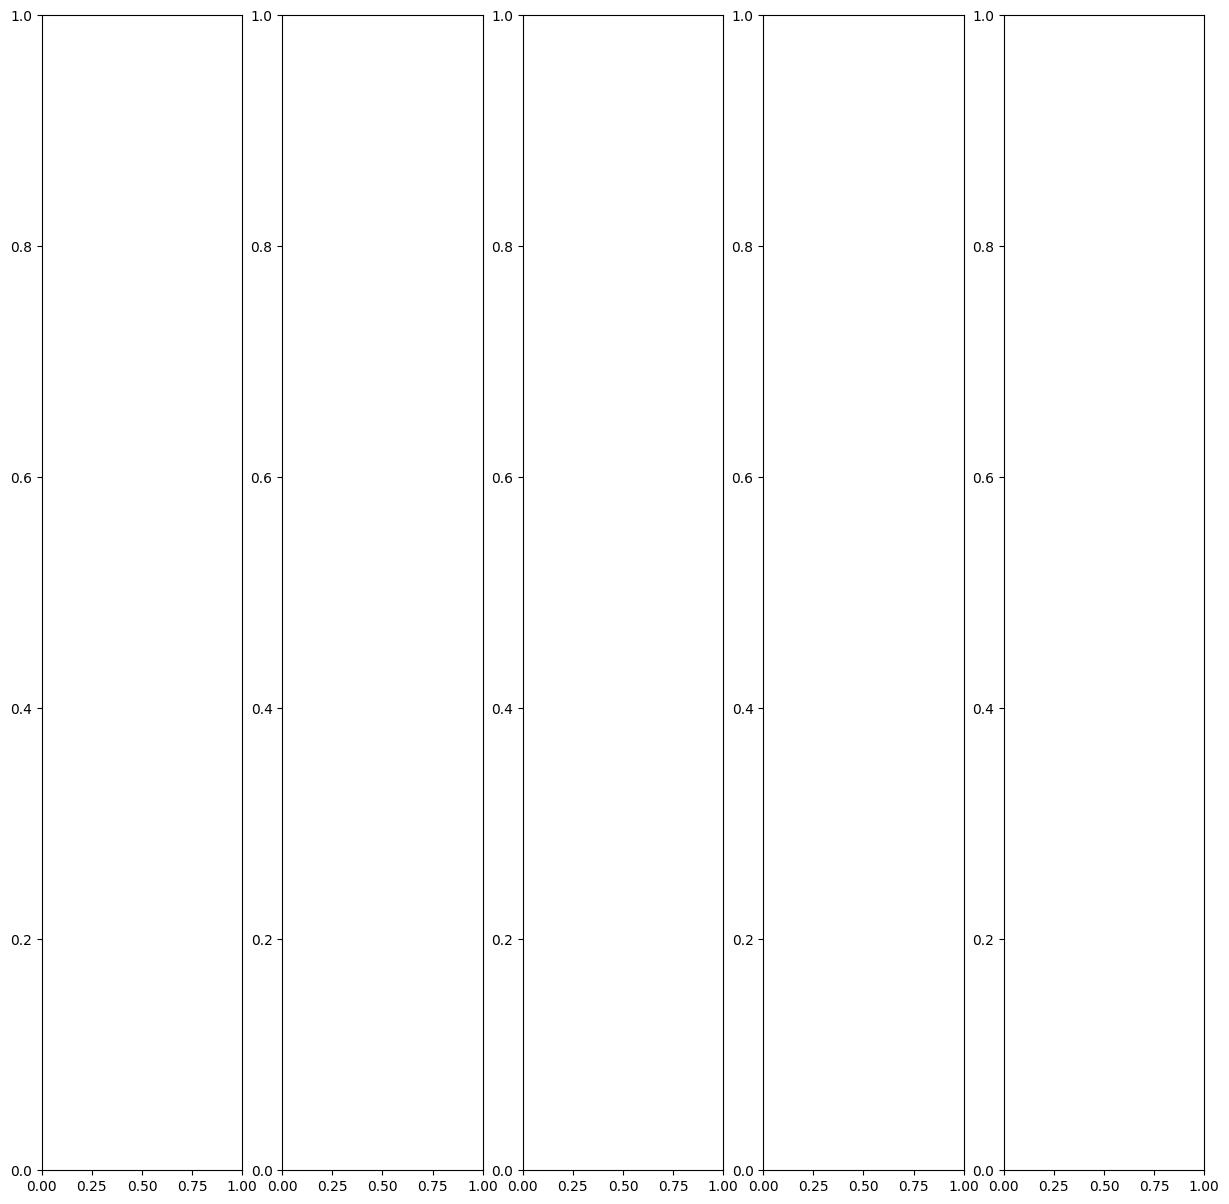

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(result):
    # 원본 이미지 가져오기
    img_path = result.orig_img
    img = img_path  # 이미지는 이미 numpy 배열로 되어 있음

    # 마스크와 박스 개수 확인
    num_masks = len(result.masks.data) if result.masks is not None else 0
    num_boxes = len(result.boxes.xyxy) if result.boxes is not None else 0

    # 마스크와 박스를 시각화할 subplot 설정
    fig, axes = plt.subplots(1, min(num_masks, num_boxes), figsize=(15, 15))
    if min(num_masks, num_boxes) == 1:
        axes = [axes]  # axes를 리스트로 변환하여 반복문에서 사용 가능하게 함

    for i in range(min(num_masks, num_boxes)):
        # 원본 이미지 복사
        img_copy = img.copy()

        # 마스크 그리기
        if result.masks is not None:
            mask_array = result.masks.data[i].cpu().numpy().astype(np.uint8)  # 마스크를 numpy 배열로 변환 (GPU에서 CPU로 이동)

            # 마스크를 원본 이미지 크기로 리사이즈
            mask_resized = cv2.resize(mask_array, (img_copy.shape[1], img_copy.shape[0]), interpolation=cv2.INTER_NEAREST)

            img_copy[mask_resized > 0] = [0, 0, 255]  # 마스크 영역을 빨간색으로 표시

        # 해당 인덱스의 박스 그리기
        if result.boxes is not None:
            box = result.boxes.xyxy[i]  # 해당 인덱스의 박스 좌표
            confidence = result.boxes.conf[i].item()  # 신뢰도를 일반 숫자로 변환
            class_id = int(result.boxes.cls[i].item())  # 클래스 ID 변환

            # 바운딩 박스를 그리기 위해 좌표 추출
            x1, y1, x2, y2 = box
            width, height = x2 - x1, y2 - y1

            # matplotlib Rectangle을 이용해 박스 그리기
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='lime', facecolor='none')
            axes[i].add_patch(rect)

            # 레이블 추가
            label = f"{model.names[class_id]}: {confidence:.2f}"
            axes[i].text(x1, y1 - 10, label, fontsize=10, color='lime', weight='bold')

        # 결과 이미지 시각화
        axes[i].imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))  # OpenCV는 BGR 포맷을 사용하므로 RGB로 변환
        axes[i].axis('off')  # 축 숨기기
        axes[i].set_title(f"Mask & Box {i + 1}")  # 타이틀 추가

    plt.tight_layout()
    plt.show()

# 첫 번째 결과를 시각화
visualize_predictions(results_test[0])
